## Import libraries, define model to evaluate. Configuration here

This is a notebook to help you quickly validate your trained models, visualize model output for sanity checking, and saving results for display in README later.

In [103]:
import numpy as np
import tensorflow as tf
import cv2
import os, datetime, yaml, random, math
from pprint import pprint
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
%matplotlib inline

MODEL_PATH = "ros/src/tl_detector/light_classification/models/"

# TODO: add new model here
SSD_CLASSIFIER = 'ssd_classifier'

# TODO: Add your model -> filepath mapping here
MODEL = {
    SSD_CLASSIFIER : 'ssd_inception_v2_coco_retrained_sim/frozen_inference_graph.pb',
}

# TODO: choose your model
CHOSEN_MODEL = SSD_CLASSIFIER

## YAML files
VALIDATION_YAML_REAL_CONFIG = 'data/validation/real_training_data/real_data_annotations.yaml'
VALIDATION_YAML_SIM_CONFIG = 'data/validation/sim_training_data/sim_data_annotations.yaml'

# TODO: set simulator or real data
IS_SIM = True
if IS_SIM:
    CHOSEN_CONFIG = VALIDATION_YAML_SIM_CONFIG
    BASE_PATH = 'data/validation/sim_training_data/'
else:
    CHOSEN_CONFIG = VALIDATION_YAML_REAL_CONFIG
    BASE_PATH = 'data/validation/real_training_data/'

config = None
with open(CHOSEN_CONFIG) as f:
    config = yaml.safe_load(f)

    
# Set number of files to visualize
NUM_TO_VISUALIZE = 12


# Constants
IMAGE_WIDTH = 800
IMAGE_HEIGHT = 600

In [92]:
# Helpers
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

def class_to_label(predicted_cls):
	if predicted_cls == 1:
		return 'green'
	elif predicted_cls == 2:
		return 'red'
	elif predicted_cls == 3:
		return 'yellow'
	else:
		return 'unknown'

# Helper function to plot graphs and figures
def plot_figures(figures, figSize, r = 1, c=1, labels=None):
    fig, axs = plt.subplots(ncols=c, nrows=r, figsize=figSize)
    axs = axs.ravel()
    for index, title in zip(range(len(figures)), figures):
        axs[index].imshow(figures[title])
        if(labels != None):
            axs[index].set_title(labels[index])
        else:
            axs[index].set_title(title)
            
        axs[index].set_axis_off()
    plt.tight_layout()
    
def bgr_to_rgb(bgr_img):
    b,g,r = cv2.split(bgr_img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    return rgb_img

def get_class_from_config(config_item):
    if (len(config_item['annotations']) == 0):
        return 'Nothing'
    first_annotation = config_item['annotations'][0]
    return first_annotation['class']

def draw_bb_box(image, annotation):
    """
        Draws a bounding box around detections
        Modifies original image
        Expects annnotation to be a dict like this:
        {
            class: Red, 
            x_width: 70.07999999999993, 
            xmin: 695.6800000000001, 
            y_height: 154.88,
            ymin: 194.24
        }
    """
    x = int(annotation['xmin'])
    y = int(annotation['ymin'])
    w = int(annotation['x_width'])
    h = int(annotation['y_height'])
    color = (255,255,255) # default white
    if annotation['class'].lower() == 'red':
        color = (255, 0, 0)
    elif annotation['class'].lower() == 'yellow':
        color = (255, 255, 0)
    elif annotation['class'].lower() == 'green':
        color = (0, 255, 255)
    else:
        pass
    cv2.rectangle(image, (x, y), (x+w, y+h), color, 4)
    
def draw_bb_boxes(image, annotations):
    for a in annotations:
        draw_bb_box(image, a)

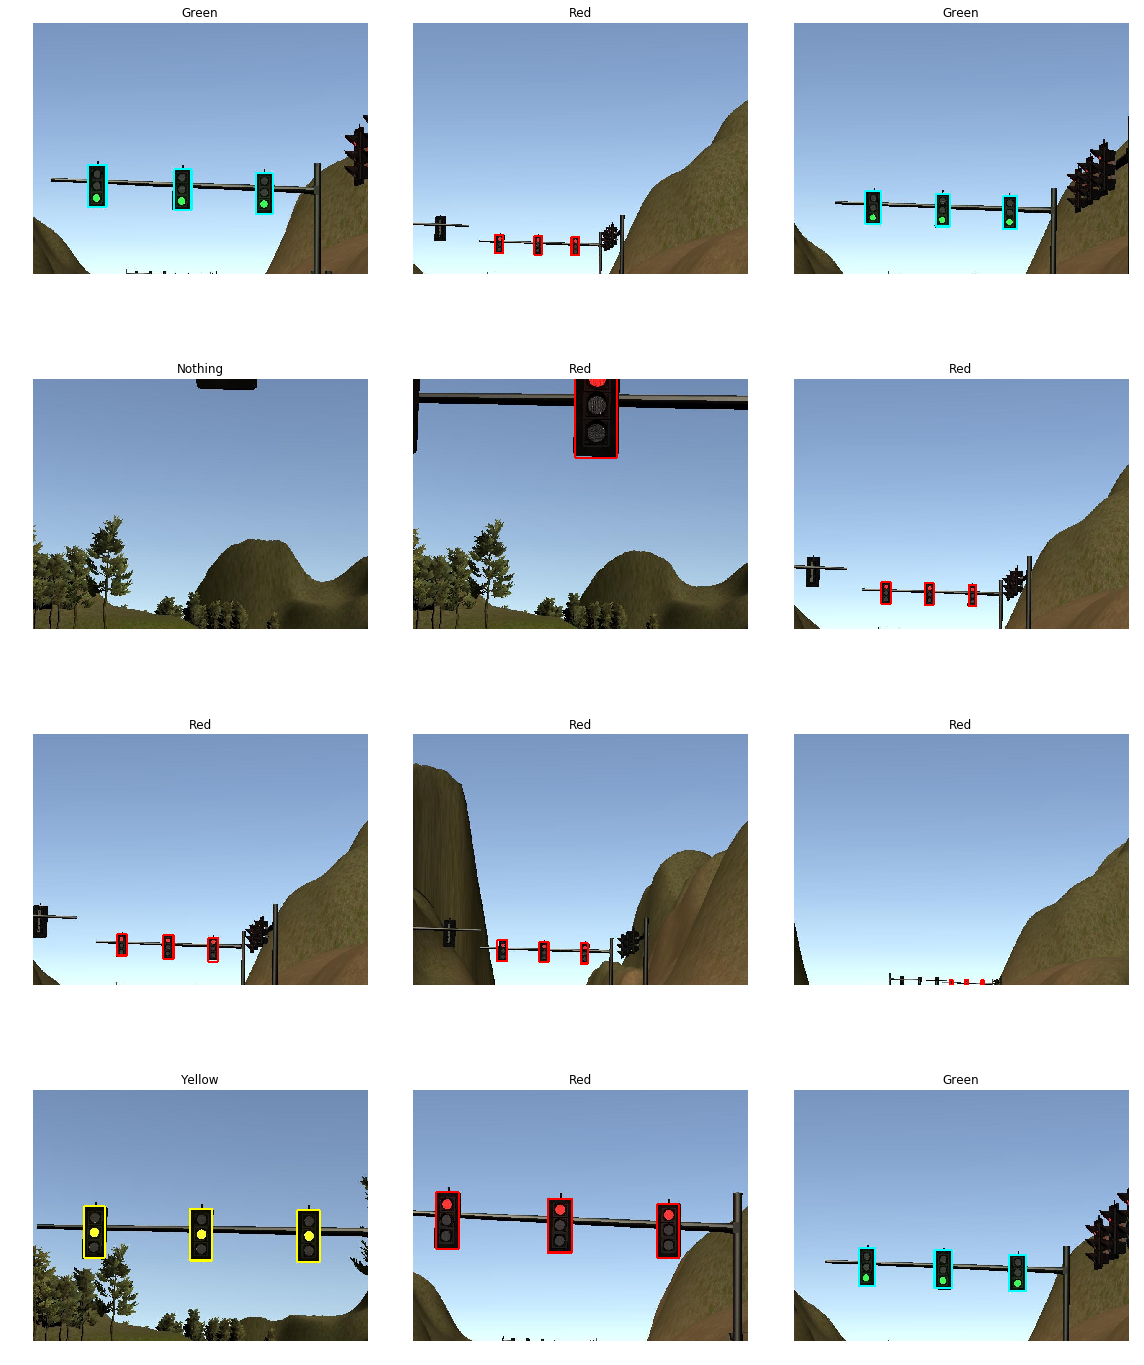

In [90]:
# Visualize the images before detection

random.shuffle(config)
config_items = [x for x in config[:NUM_TO_VISUALIZE]]
files_to_load = [x['filename'] for x in config_items]

labels = []
vimages = {}
for i in range(0, NUM_TO_VISUALIZE):
    filepath = os.path.join(BASE_PATH, files_to_load[i])
    labels.append(get_class_from_config(config_items[i]))
    original_img = bgr_to_rgb(cv2.imread(filepath, 1))
    draw_bb_boxes(original_img, config_items[i]['annotations'])
    vimages[i] = original_img
    
plot_figures(vimages, (16,20), 4, 3, labels)
plt.savefig("./report/visualization")


Time: 1.7285, SCORES: 0.998273, CLASSES: green
Time: 0.3789, SCORES: 0.999672, CLASSES: red
Time: 0.3656, SCORES: 0.996442, CLASSES: green
Time: 0.3454, SCORES: 0.160787, CLASSES: red
Time: 0.3602, SCORES: 0.990979, CLASSES: red
Time: 0.4031, SCORES: 0.998769, CLASSES: red
Time: 0.4016, SCORES: 0.995998, CLASSES: red
Time: 0.3872, SCORES: 0.999761, CLASSES: red
Time: 0.3878, SCORES: 0.827580, CLASSES: red
Time: 0.3617, SCORES: 0.835014, CLASSES: yellow
Time: 0.3588, SCORES: 0.948396, CLASSES: red
Time: 0.3445, SCORES: 0.996587, CLASSES: green


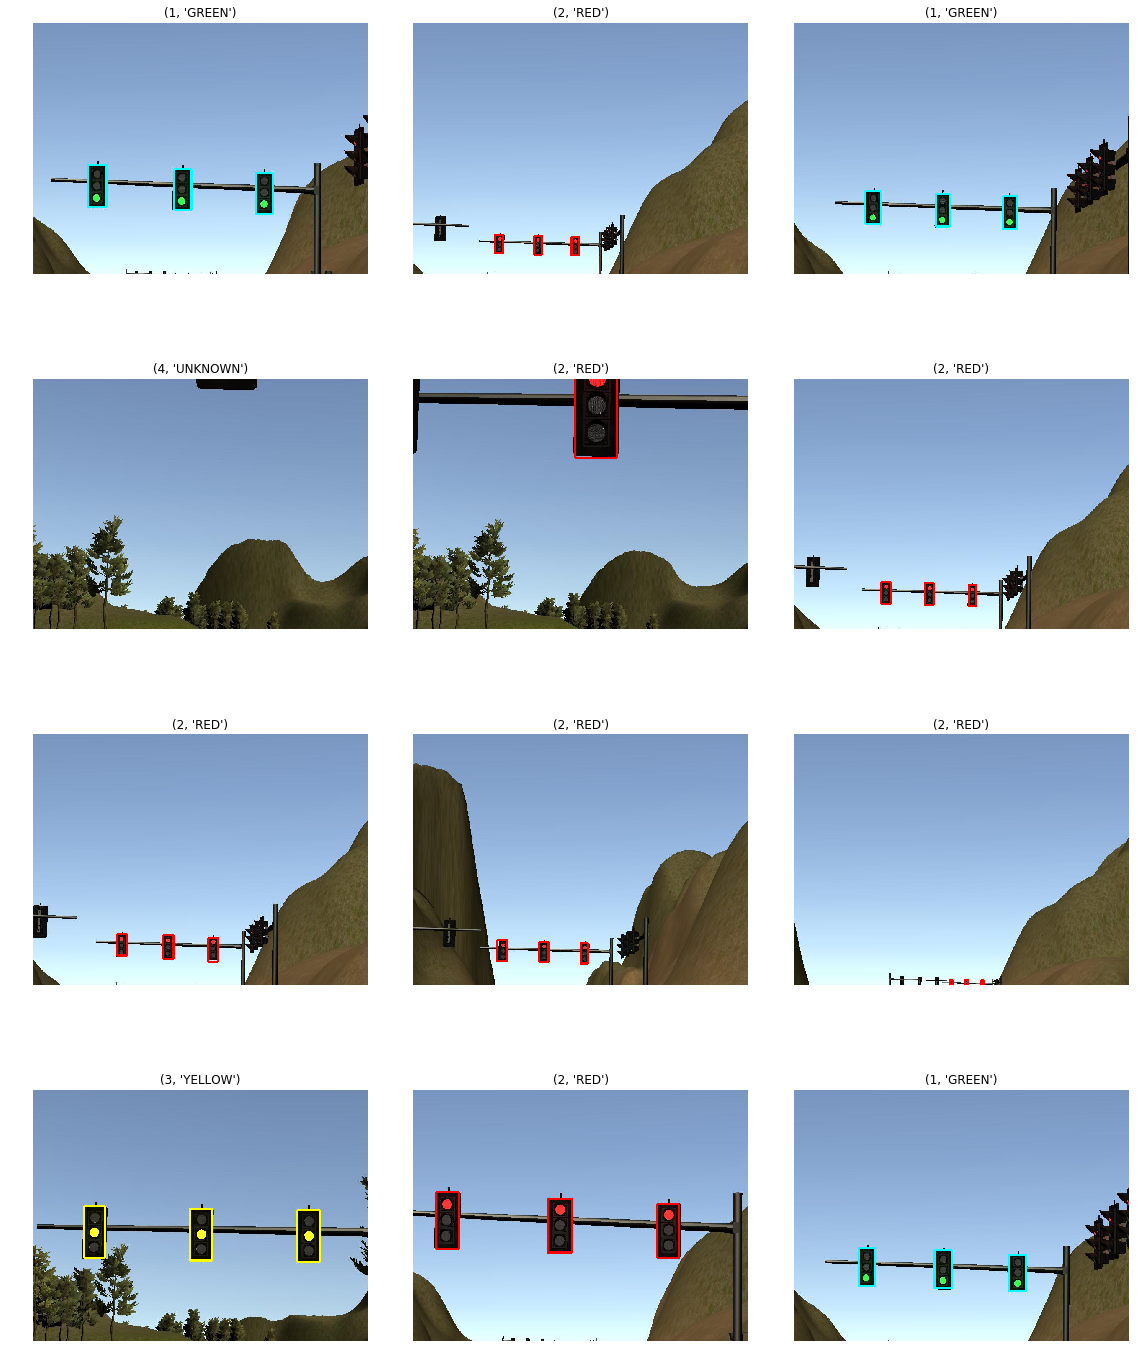

In [104]:
# Visualize the images after detection

def classify(sess, graph, image, image_tensor, boxes, scores, classes, num_detections):
    """ 
        Now: returns (classID, label) of highest scoring prediction
        TODO: returns list of annotation object
    """
    with graph.as_default():
        img_expand = np.expand_dims(image, axis=0)
        start = datetime.datetime.now()
        (boxes, scores, classes, num_detections) = sess.run(
            [boxes, scores, classes, num_detections],
            feed_dict={image_tensor: img_expand})
        end = datetime.datetime.now()
        c = end - start

    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes).astype(np.int32)

    print('Time: %.4f, SCORES: %.6f, CLASSES: %s' % (c.total_seconds(), scores[0], class_to_label(classes[0])))
    # annotations = []

    if scores[0] > 0.5:
        if classes[0] == 1:
            return (1, 'GREEN')
        elif classes[0] == 2:
            return (2, 'RED')
        elif classes[0] == 3:
            return (3, 'YELLOW')
    return (4, 'UNKNOWN')

graph = tf.Graph()
threshold = 0.5

image_tensor = None
boxes = None
scores = None
classes = None

graph = load_graph(MODEL_PATH + MODEL[CHOSEN_MODEL])
image_tensor = graph.get_tensor_by_name('image_tensor:0')
boxes = graph.get_tensor_by_name('detection_boxes:0')
scores = graph.get_tensor_by_name('detection_scores:0')
classes = graph.get_tensor_by_name('detection_classes:0')
num_detections = graph.get_tensor_by_name('num_detections:0')

sess = tf.Session(graph=graph)

labels = []
labeledImgs = {}
for i in range(0, NUM_TO_VISUALIZE):
    filepath = os.path.join(BASE_PATH, files_to_load[i])
    img = Image.open(filepath)
    numpyImg = np.asarray(img)
    result = classify(sess, graph, img, image_tensor, boxes, scores, classes, num_detections)
    draw_bb_boxes(numpyImg, config_items[i]['annotations'])
    labeledImgs[i] = numpyImg
    labels.append(result)
plot_figures(labeledImgs, (16,20), 4, 3, labels)
plt.savefig('./report/results')

In [ ]:
# Run full evaluation